## Notebook Contents 

### Library Imports

In [102]:
import ee                                                   # Pull Google Earth Engine Images 
import geemap                                               # Map and display features 
import json                                                 # Convert json files into python dicts
import pandas as pd                                         # For csv files
import numpy as np
import geopandas as gpd                                     # Creating gdf using geometry 
from datetime import datetime                               # For GEE dates 
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from jenkspy import jenks_breaks
from scipy.stats import pearsonr

### Authenticate Earth Engine Server

In [103]:
ee.Authenticate()
ee.Initialize()

### **Bands, Resolution, Utility**
- Sentinel Bands Used: B3 (green, 10m), B4 (red, 10m), B5 (red edge, 20m), B8 (NIR, 10m)
- Sentinel-2 has a 5 day revisit time (best satellite to optimize temporal resolution)
- Script calculates the percentage of a lagoon covered by a harmful bloom (depends on variable)
- Below find the calculations for relevant indices: 

**Normalized Difference Chlorophyll Index Calculation:**
$$NDCI = \frac{B5 - B4}{B5 + B4}$$

**Normalized Difference Chlorophyll Index Calculation (Wavelength):**
$$NDCI = \frac{705nm - 665nm}{705nm + 665nm}$$

**Normalized Difference Water Index Calculation:**
$$NDWI = \frac{B3 - B8}{B3 + B8}$$

**Normalized Difference Water Index Calculation:**
$$NDWI = \frac{560nm - 842nm}{560nm + 842nm}$$

<sup>*nm indicating nanometers</sup>

### GeoDataFrame creation and ensure geometry is functional 
- Create the gdf to load data 
- Project to the WGS 84 (proper projection for GEE)
- Convert gdf to GeoJson so it can be read by GEE
- Create an Earth Engine feature collection from the parsed GeoJson file

**IMPORTANT:** Check the geometry of the set when finished to ensure the vector data loaded properly

In [104]:
# Create GeoDataFrame (similar to Pandas)
gdf = gpd.read_file("../../Data/lagoon_polygons/krusenstern.geojson")

# Convert to WGS 84
gdf = gdf.to_crs("EPSG:4326")

# Create feature collection (this is how Earth Engine stores polygons/a set of vector values)
geojson_str = gdf.to_json()
lagoon_fc = ee.FeatureCollection(json.loads(geojson_str))

# IMPORTANT! 
# Check geometry to ensure files loaded properly 
# Include .head(3) for large dataset 
print(f"GeoDataFrame Geometry: {gdf['geometry'].head(3)}")

GeoDataFrame Geometry: 0    POLYGON ((-163.53176 67.15001, -163.53286 67.1...
Name: geometry, dtype: geometry


### Basic Lagoon Visualization for Context

- Surface Reflectance (SR) is perfered as it comes pre corrected compared to Top of Atmosphere (TOA)
- More can be found on the [Sentinel2 Earth Engine Page](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED)
- Previous Copernicus dataset was deprecated at the end of 2024 so the ```HARMONIZED``` set is used

In [144]:
# Define ROI
ROI = lagoon_fc

# Sentinel2 cloud mask (recommend mask from GEE)
def mask_s2_clouds(image):
  """
  Masks clouds in a Sentinel-2 image using the QA band.

  Args:
      image (ee.Image): A Sentinel-2 image.

  Returns:
      ee.Image: A cloud-masked Sentinel-2 image.
  """
  qa = image.select('QA60')

  # Bits 10 and 11 are clouds and cirrus, respectively.
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11

  # Both flags should be set to zero, indicating clear conditions.
  mask = (
      qa.bitwiseAnd(cloud_bit_mask)
      .eq(0)
      .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  )

  return image.updateMask(mask).divide(10000)

trueColor = (
  ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
  .filterDate('2024-06-22', '2024-06-24')
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
  .map(mask_s2_clouds)
  .median()
  .clip(ROI)
)

# Define bands to be visualized for true color image
trueColorVisualization = {
  'min': 0.0,
  'max': 0.3,
  'bands': ['B4', 'B3', 'B2']
}

# Define visualization for Krusenstern polygon
polygonVisualization = {
  'color': 'B27300',
  'width': 5,
  'fillColor': 'B27300',
  'fillColorOpacity': 0.5
}

# Set up map 
Map = geemap.Map(center=[67.15, -163.65], zoom=11.25)
Map.add_basemap("HYBRID")
Map.addLayer(ROI, polygonVisualization, 'Krusentern Lagoon Polygon')
Map.addLayer(trueColor, trueColorVisualization, "True Color")
Map

Map(center=[67.15, -163.65], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

### Lagoon Visualization Output and Key Components 

**Output:**

<img src="Images/polygonDemo.png" width="450" alt="polygonDemo" />

- Layers can be selected on the right and are ordered sequentially as they are typed out as ```Map.addLayer...```


### Basic NDCI Visualization for Context

- Create a normalized difference function for NDCI
- Add NDCI visualization to the map

In [106]:
# Function to calculate NDCI
def calculate_ndci(image):
    """
    Displays the Normalized Difference Chlorophyll Index (NDCI)

    Args:
        image (ee.Image): A Sentinel-2 image.

    Returns:
        ee.Image: A NDCI Sentinel-2 image.
    """
    ndci = image.normalizedDifference(['B5', 'B4']).rename('NDCI')
    return image.addBands(ndci)

collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(ROI)
    .filterDate('2024-06-22', '2024-06-24')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .map(mask_s2_clouds)
    .map(calculate_ndci)
)

# Display amount of collected images in input range
image_count = collection.size().getInfo()
print(f'Number of cloud-free images found: {image_count}')

# Print image dates from system:index
image_list = collection.toList(collection.size())
indices = ee.List.map(
    image_list,
    lambda img: ee.Image(img).get('system:index')
)
for idx in indices.getInfo():
    date_str = idx[:8]  # Extract YYYYMMDD
    print(f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:8]}")

# Aggregate the images and clip the ROI bounds
addNDCI = (
    collection
    .median()
    .clip(ROI)
)

# Visualization parameters 
ndciVisualization = {
    "bands": ['NDCI'],
    "min": 0,
    "max": 0.5,     # Editing the range of min/max values effects the visualization  
                    # e.g. if max is set to 0.2 for NDCI more of the image will appear red 
    "palette": ['blue', 'green', 'red']
}

# Add layers to map
Map.addLayer(addNDCI, ndciVisualization, 'Sentinel-2 NDCI')
Map

# Note: The true color layer can be toggled on and off as well

Number of cloud-free images found: 1
2024-06-23


Map(center=[67.15, -163.65], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

### Importing and Visualizing Field Sample Locations

- Field samples used in data analysis were taken starting in the summer of 2021
- All field samples are were measured in FNU (Formazin Nephelometric Units)
- To view the raw CSV file see [Krusenstern Sampling Data](../../Data/field_collection/krusenstern_sampling_data.csv)

In [107]:
# Import locations CSV file
df_location = pd.read_csv("../../Data/field_collection/krusenstern_locations.csv")
df_location.head()

,Location,Latitude,Longitude
0,Outflow,67.133307,-163.516492
1,Inlet,67.189610,-163.696541
2,Marine Edge,67.168725,-163.730818
3,Center,67.148385,-163.652018
4,R1,67.124447,-163.570947


In [108]:
# Import Sampling Data
df_sampling = pd.read_csv("../../Data/field_collection/krusenstern_sampling_data.csv")
df_sampling.head()

,Date,Location,Turbidity (FNU),Chlorophyl_ug/L,BGA (ug/L),Chlorophyl (FNU),BGA (FNU)
0,6/27/2017,Outflow,17.31,10.41,1.08,NaN,NaN
1,7/15/2017,Outflow,42.60,36.79,12.09,NaN,NaN
2,8/19/2017,Outflow,42.52,10.97,0.73,NaN,NaN
3,6/27/2017,Center,22.60,16.63,1.38,NaN,NaN
4,7/15/2017,Center,26.70,10.20,2.71,NaN,NaN


In [109]:
# Create a join based on "Location Data"
df_merge = pd.merge(df_location, df_sampling, how='left', on = 'Location')

# Format date info to align with Earth Engine formatting (YYYY-MM-DD)
df_merge['Date'] = pd.to_datetime(df_merge['Date'], errors='coerce')
df_merge = df_merge.sort_values(by = 'Date', ascending = True)
df_merge['Date'] = df_merge['Date'].dt.strftime('%Y-%m-%d')
df_merge.tail(5)

,Location,Latitude,Longitude,Date,Turbidity (FNU),Chlorophyl_ug/L,BGA (ug/L),Chlorophyl (FNU),BGA (FNU)
9,Outflow,67.133307,-163.516492,2024-06-21,44.90,NaN,NaN,6.86,2.09
65,R3,67.151358,-163.693318,2024-06-21,14.82,NaN,NaN,2.93,0.78
37,Center,67.148385,-163.652018,2024-06-21,17.50,NaN,NaN,3.81,0.98
55,R2,67.152245,-163.610671,2024-06-21,28.60,NaN,NaN,13.20,2.22
46,R1,67.124447,-163.570947,2024-06-21,14.95,NaN,NaN,3.08,0.80


In [110]:
# Visualize the points as a layer 
y = df_location['Latitude']
x = df_location['Longitude']
Map.add_points_from_xy(df_location, x="Longitude", y="Latitude", layer_name="Sampling Points")
Map


Map(center=[67.15, -163.65], controls=(WidgetControl(options=['position', 'transparent_bg'], position='toprigh…

### Buffer Collection Points 

- Extract NDCI values in a 20m buffer around points 

In [111]:
# Function to mask land 

# Not really necessary in this case as the polygons were re-drawn to 
# Eliminate any possible overlap with land 
def mask_land(image):
    """
    Masks land in a Sentinel-2 image using the QA band.

    Args:
        image (ee.Image): A Sentinel-2 image.

    Returns:
        ee.Image: A land-masked Sentinel-2 image.
    """
    ndwi = image.normalizedDifference(['B3','B8']).rename('NDWI')
    water_mask = ndwi.gt(0.1)
    return image.updateMask(water_mask)

In [112]:
# Toggle start and end date (Only first image will be chosen)
start_date = '2020-06-20'
end_date = '2020-06-30'

sentinel2_collection = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    .filterBounds(ROI)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .map(calculate_ndci)
    .map(mask_land)
)

print(f'Number of images:, {sentinel2_collection.size().getInfo()}')

# Select first Image
image = sentinel2_collection.first()

# Print Image date
image_date = ee.Date(image.get('system:time_start'))
print(f'Image date:, {image_date.format('YYYY-MM-dd').getInfo()} \n')

# Clip image
clipped_img = image.clip(ROI)

# Convert DataFrame to Earth Engine FeatureCollection
def df_to_fc(df):
    features = []
    for idx, row in df.iterrows():
        point = ee.Geometry.Point([row['Longitude'], row['Latitude']])
        feature = ee.Feature(point, {'location': row['Location']})
        features.append(feature)
    return ee.FeatureCollection(features)

points_fc = df_to_fc(df_location)

# Create 20m buffer around each point (2-pixel radius)
def buffer_points(feature):
    return feature.buffer(20)

buffered_points = points_fc.map(buffer_points)

# Sample with mean reducer
ndci_samples = clipped_img.select('NDCI').reduceRegions(
    collection=buffered_points,
    reducer=ee.Reducer.mean(),
    scale=20
)

# Print results
print('NDCI values at points:')
samples = ndci_samples.getInfo()['features']
for sample in samples:
    location = sample['properties'].get('location', 'Unknown')
    ndci = sample['properties'].get('mean', 'No data')
    print(f'{location}: NDCI = {ndci:.4f}')

# The bloom does not really need to be visualized but you can
# uncomment the following if you would like to 

# # NDCI viz parameters
# vis_ndci = {
#     'bands': ['NDCI'],
#     'min': 0, 'max': 0.5,
#     'palette': ['blue', 'green', 'yellow', 'orange', 'red']
# }

# # Map viz parameters 
# vis_params = {
#     'bands': ['B4', 'B3', 'B2'],
#     'min': 0,
#     'max': 2000,
#     'gamma': 1.5
# }

# Map.addLayer(clipped_img, vis_params, 'ROI')
# Map.addLayer(lagoon_fc, {'color': 'd2e0fe'}, 'Region of Interest (ROI)')
# Map.addLayer(clipped_img, vis_ndci, 'NDCI')
# Map.addLayer(buffered_points, {'color': 'yellow'}, 'Sampling Points (20m buffer)')
# Map.addLayer(points_fc, {'color': 'red'}, 'Point Locations')
# Map

Number of images:, 2
Image date:, 2020-06-20 

NDCI values at points:
Outflow: NDCI = 0.1881
Inlet: NDCI = 0.0170
Marine Edge: NDCI = 0.1571
Center: NDCI = 0.2188
R1: NDCI = 0.2068
R2: NDCI = 0.2069
R3: NDCI = 0.2067
R4: NDCI = 0.2686
R5: NDCI = 0.2348


### Validation Dataset

In [113]:
# Observed NDCI buffer values
ndci = [-0.1241, -0.0693, -0.0836, -0.0676, -0.1021, -0.1314, -0.061, 0, 0.1874, 
        -0.0552, 0.136, 0.0645, 0.0727, 0.1318, 0.0603, 0.1527, 0.1076, 0.0558]

# Field measurements

# Field Chlorophyll 
chlorophyll_fnu = [0.86, 2.21, 2.5, 2.23, 0.74, 0.82, 2.95, 1.87, 3.92, 0.42, 
                   9.02, 0.95, 0.78, 13.2, 6.86, 3.81, 2.93, 3.08]

# Field Turbidity
turbidity_fnu = [-0.63, 2.69, 2.06, 0.62, -1.53, 1.73, 29.47, 9.85, 18.98, 5.05, 
                 22.76, 21.66, 4.87, 28.6, 44.9, 17.5, 14.82, 14.95]

# Field BGA
bga_fnu = [0.19, 0.38, 0.5, 0.34, 0.17, 0.21, 1.18, 0.55, 0.93, 0.27, 
           1.65, 1.69, 0.34, 2.22, 2.09, 0.98, 0.78, 0.8]

# Zip data into DataFrame
comp_data = list(zip(ndci, chlorophyll_fnu, turbidity_fnu, bga_fnu))
comp_df = pd.DataFrame(comp_data, columns = ['NDCI', 'Chlorophyll', 'Turbidity', 'BGA'])
comp_df

,NDCI,Chlorophyll,Turbidity,BGA
0,-0.1241,0.86,-0.63,0.19
1,-0.0693,2.21,2.69,0.38
2,-0.0836,2.50,2.06,0.50
3,-0.0676,2.23,0.62,0.34
4,-0.1021,0.74,-1.53,0.17
5,-0.1314,0.82,1.73,0.21
6,-0.0610,2.95,29.47,1.18
7,0.0000,1.87,9.85,0.55
8,0.1874,3.92,18.98,0.93
9,-0.0552,0.42,5.05,0.27


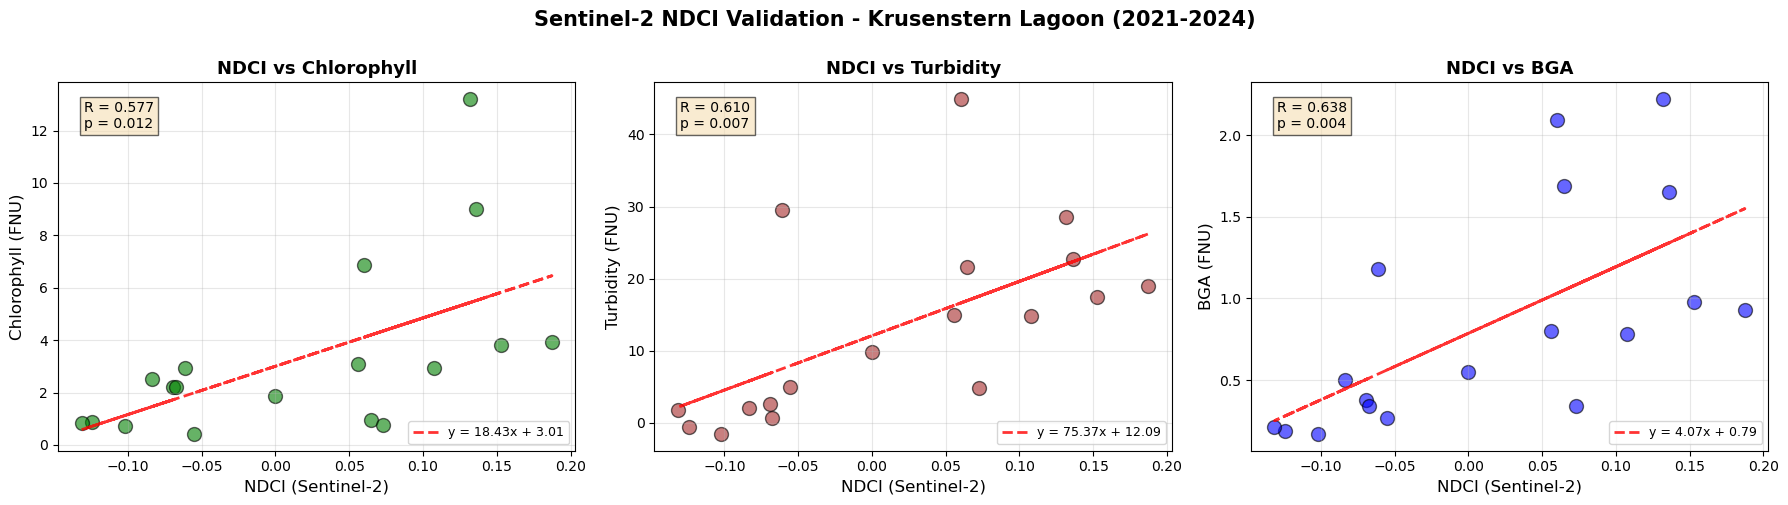

In [114]:
# Validation plots 

# Create figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Function to create each subplot with consistent styling
def create_subplot(ax, x_data, y_data, y_label, color, title):
    """
    Scatter plot with trend line and statistics
    """
    # Scatter plot
    ax.scatter(x_data, y_data, s=100, alpha=0.6, edgecolors='black', color=color)
    ax.set_xlabel('NDCI (Sentinel-2)', fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    # Add linear trend line
    z = np.polyfit(x_data, y_data, 1)
    p = np.poly1d(z)
    ax.plot(x_data, p(x_data), "r--", alpha=0.8, linewidth=2, 
            label=f'y = {z[0]:.2f}x + {z[1]:.2f}')
    
    # Calculate Pearson correlation
    r, p_value = pearsonr(x_data, y_data)
    
    # Add statistics box
    stats_text = f'R = {r:.3f}\np = {p_value:.3f}'
    ax.text(0.05, 0.95, stats_text, 
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='square', facecolor='wheat', alpha=0.6))
    
    ax.legend(loc='lower right', fontsize=9)
    
    return r, p_value

# Create each subplot
r_chlor, p_chlor = create_subplot(axes[0], ndci, chlorophyll_fnu, 
                                   'Chlorophyll (FNU)', 'green',
                                   'NDCI vs Chlorophyll')

r_turb, p_turb = create_subplot(axes[1], ndci, turbidity_fnu, 
                                 'Turbidity (FNU)', 'brown',
                                 'NDCI vs Turbidity')

r_bga, p_bga = create_subplot(axes[2], ndci, bga_fnu, 
                               'BGA (FNU)', 'blue',
                               'NDCI vs BGA')

# Main title
fig.suptitle('Sentinel-2 NDCI Validation - Krusenstern Lagoon (2021-2024)', 
             fontsize=15, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

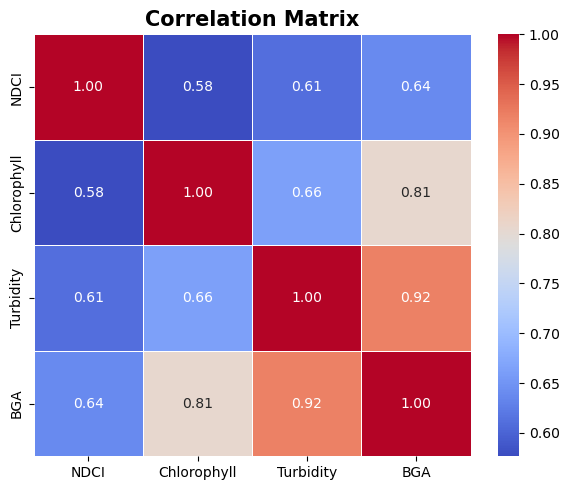

In [115]:
# Compute correlation matrix
corr = comp_df.corr(numeric_only=True)

# Plot from in class exercise modeled to my data
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=15, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [116]:
# Create three breaks for classes using jenks 
breaks = jenks_breaks(ndci, n_classes=3)
breaks

[np.float64(-0.1314),
 np.float64(-0.0552),
 np.float64(0.0727),
 np.float64(0.1874)]

### NDCI classes based on observed field samples and satellite derived indices    

__None__: < -0.0553

__Low__: -0.0552 - 0.0727

__Medium__: 0.0727 - 0.1874

__High__: > 0.1874

In [117]:
# Function to set bloom severity thresholds 

def classify_bloom(image):
    """
    Classifies algal bloom severity using NDCI threshold values.

    Bloom classes are defined as:
        0 = No bloom
        1 = Low bloom
        2 = Medium bloom
        3 = High bloom

    Args:
        image (ee.Image): An Earth Engine image containing an 'NDCI' band.

    Returns:
        ee.Image: The input image with an added 'bloom_class' band representing
        bloom severity as integer class values.
    """

    ndci = image.select('NDCI')

    # Classify bands

    # Using .multiply to Convert boolean NDCI thresholds (0/1) into integer bloom class labels
    none = ndci.lt(-0.0552).multiply(0)
    low = ndci.gte(-0.0552).And(ndci.lt(0.0727)).multiply(1)
    medium = ndci.gte(0.0727).And(ndci.lt(0.1874)).multiply(2)
    high = ndci.gte(0.1874).multiply(3)
    
    # Combine into single classification band
    bloom_class = none.add(low).add(medium).add(high).rename('bloom_class')
    
    return image.addBands(bloom_class)

In [118]:
def calculate_class_percentages(image, region):
    """
    Calculate percentage of each bloom class.

    Args:
        image (ee.Image): An Earth Engine image containing a 'bloom_class' band.
        region (ee.Geometry): The region over which to compute class statistics.

    Returns:
        ee.Image: Input image with properties for total pixel count
        and class pixel counts
    """
    bloom_class = image.select('bloom_class')
    
    # Get total pixel count (excluding masked areas)
    total_pixels = bloom_class.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=region,
        scale=20,
        maxPixels=1e9
    ).get('bloom_class')
    
    # Calculate area for each class
    class_areas = {}
    for class_val in [0, 1, 2, 3]:
        # Create mask for this class
        class_mask = bloom_class.eq(class_val)
        
        # Count pixels in this class
        class_pixels = class_mask.reduceRegion(
            reducer=ee.Reducer.sum(),
            geometry=region,
            scale=20,
            maxPixels=1e9
        ).get('bloom_class')
        
        class_areas[class_val] = class_pixels
    
    # Add properties to image
    return image.set({
        'total_pixels': total_pixels,
        'none_pixels': class_areas[0],
        'low_pixels': class_areas[1],
        'medium_pixels': class_areas[2],
        'high_pixels': class_areas[3]
    })


In [145]:
# Set your year of interest
year = 2019
start_date = f'{year}-01-01'
end_date = f'{year}-12-31'

# Build collection for the year
sentinel2_year = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterDate(start_date, end_date)
    .filterBounds(ROI)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))
    .map(calculate_ndci)
    .map(mask_land)
    .map(classify_bloom)
    .map(lambda img: calculate_class_percentages(img, ROI.geometry()))
)

print(f'Number of images in {year}:', sentinel2_year.size().getInfo())

# Extract results for each image
results = []
images_info = sentinel2_year.getInfo()['features']

class_names = {0: 'None', 1: 'Low', 2: 'Medium', 3: 'High'}

print(f'\nBloom classification percentages for {year}:\n')
print(f'{"Date":<12} {"None %":<10} {"Low %":<10} {"Medium %":<10} {"High %":<10}')
print('-' * 52)

for img_info in images_info:
    props = img_info['properties']
    
    # Get date
    date_ms = props['system:time_start']
    date = ee.Date(date_ms).format('YYYY-MM-dd').getInfo()
    
    # Get pixel counts
    total = props.get('total_pixels', 0)
    
    if total > 0:
        none_pct = (props.get('none_pixels', 0) / total) * 100
        low_pct = (props.get('low_pixels', 0) / total) * 100
        medium_pct = (props.get('medium_pixels', 0) / total) * 100
        high_pct = (props.get('high_pixels', 0) / total) * 100
        
        print(f'{date:<12} {none_pct:<10.2f} {low_pct:<10.2f} {medium_pct:<10.2f} {high_pct:<10.2f}')
        
        results.append({
            'date': date,
            'none_pct': none_pct,
            'low_pct': low_pct,
            'medium_pct': medium_pct,
            'high_pct': high_pct,
            'total_pixels': total
        })
    else:
        print(f'{date:<12} No valid data')

# Convert to DataFrame for easy analysis/export
import pandas as pd
df_results = pd.DataFrame(results)

print(f'\nSummary statistics for {year}:')
print(df_results[['none_pct', 'low_pct', 'medium_pct', 'high_pct']].describe())

# Save to CSV
# df_results.to_csv(f'bloom_classification_{year}.csv', index=False)

# Current KeyError for data from 2017-2018
# Forum Discussion: https://github.com/gee-community/geemap/discussions/2570

Number of images in 2019: 54

Bloom classification percentages for 2019:

Date         None %     Low %      Medium %   High %    
----------------------------------------------------
2019-02-13   0.00       128.63     0.00       0.00      
2019-02-28   0.42       99.56      0.02       0.00      
2019-03-12   No valid data
2019-03-12   No valid data
2019-03-15   0.53       99.49      0.02       0.00      
2019-03-18   0.72       98.68      0.30       0.00      
2019-03-20   19.47      80.05      0.40       0.00      
2019-03-27   1.58       98.42      0.00       0.00      
2019-04-01   0.07       100.01     0.00       0.00      
2019-04-02   0.25       99.79      0.00       0.00      
2019-04-04   1.04       99.03      0.00       0.00      
2019-04-06   0.83       99.24      0.00       0.00      
2019-04-09   0.00       100.06     0.00       0.00      
2019-04-11   0.00       100.03     0.00       0.00      
2019-04-12   0.00       100.01     0.00       0.00      
2019-04-16   3.62    

In [120]:
df_results.head()

,date,none_pct,low_pct,medium_pct,high_pct,total_pixels
0,2025-02-13,1.110681,99.042828,0.0,0.0,304
1,2025-02-18,1.717900,98.354206,0.0,0.0,310
2,2025-02-28,0.000000,100.318811,0.0,0.0,802
3,2025-03-13,2.642390,100.634921,0.0,0.0,42
4,2025-03-26,0.000000,98.526180,0.0,0.0,91


### Data Visualization

- Importing CSV files nad visualizing data
- Year column added

In [135]:
# Load all dataframes 
df_2019 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2019.csv")
df_2020 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2020.csv")
df_2021 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2021.csv")
df_2022 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2022.csv")
df_2023 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2023.csv")
df_2024 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2024.csv")
df_2025 = pd.read_csv("../../Notebooks/krusenstern_timeseries/bloom_classification_2025.csv")

# Add year column to each if not present
df_2019['year'] = 2019
df_2020['year'] = 2020
df_2021['year'] = 2021
df_2022['year'] = 2022
df_2023['year'] = 2023
df_2024['year'] = 2024
df_2025['year'] = 2025

# Combine all
df_comb = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023, df_2024, df_2025], ignore_index=True)

# Sort by date
df_comb['date'] = pd.to_datetime(df_comb['date'])
df_comb = df_comb.sort_values('date')

# Display
df_comb.head()

,date,none_pct,low_pct,medium_pct,high_pct,total_pixels,year
0,2019-02-13,0.000000,128.627451,0.000000,0.0,3,2019
1,2019-02-28,0.422412,99.556461,0.020537,0.0,14608,2019
2,2019-03-15,0.526526,99.487756,0.015175,0.0,6590,2019
3,2019-03-18,0.720894,98.683307,0.296736,0.0,674,2019
4,2019-03-20,19.471853,80.050601,0.403226,0.0,496,2019


### Graphs 

- All graphs are a work in progress
- Data from 2017 and 2018 is still under collection

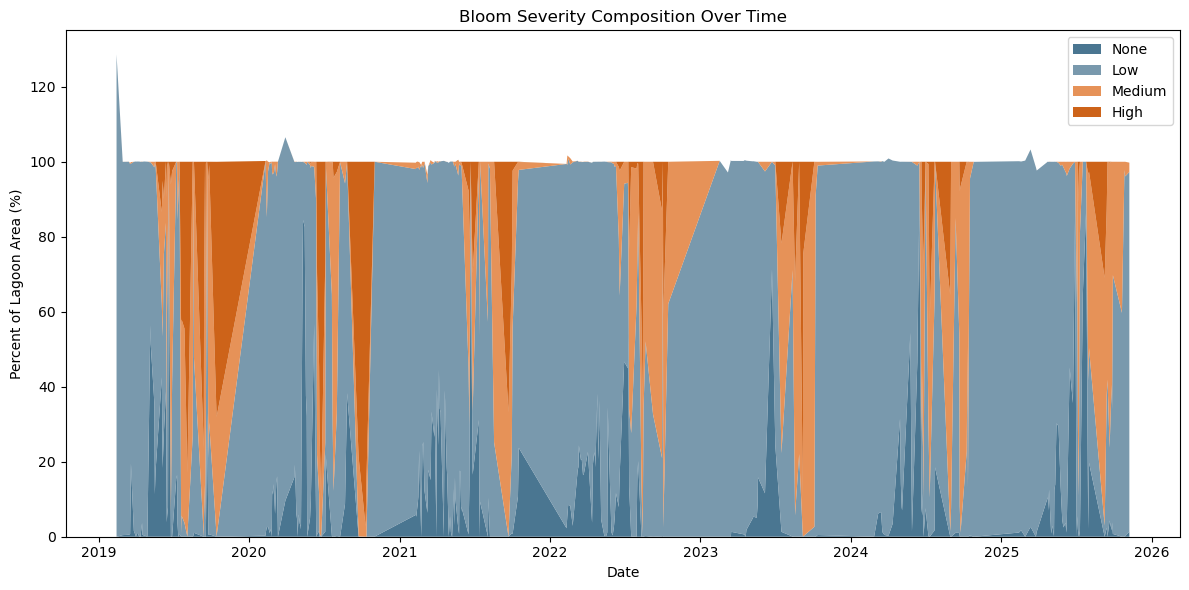

In [136]:
# Ensure datetime
df = df_comb.copy()

plt.figure(figsize=(12, 6))

plt.stackplot(
    df['date'],
    df['none_pct'],
    df['low_pct'],
    df['medium_pct'],
    df['high_pct'],
    labels=['None', 'Low', 'Medium', 'High'],
    colors=[ '#366785','#6b8ea4', '#e48646', '#c85200'],    # https://www.color-hex.com/color-palette/1034884
    alpha=0.9
)

plt.ylabel('Percent of Lagoon Area (%)')
plt.xlabel('Date')
plt.title('Bloom Severity Composition Over Time')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


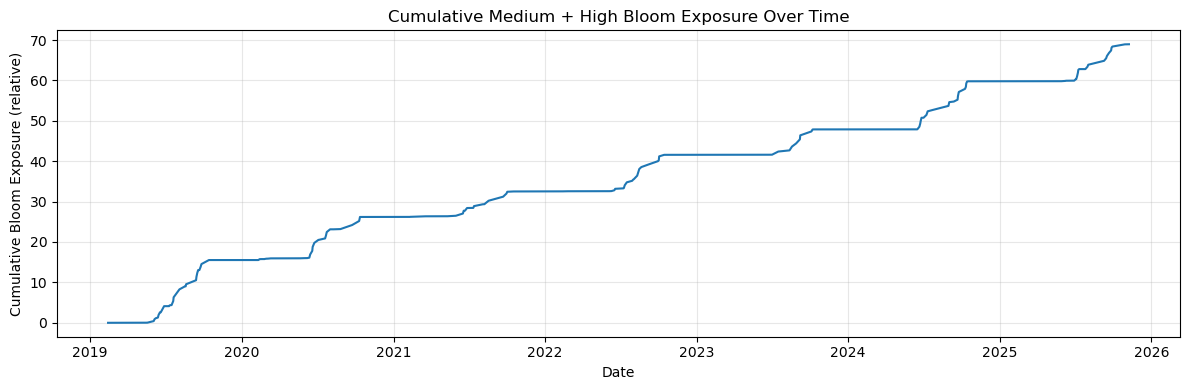

In [137]:
df['med_high_pct'] = df['medium_pct'] + df['high_pct']

df['days_since_start'] = (df['date'] - df['date'].min()).dt.days
df['cumulative_exposure'] = (df['med_high_pct'] / 100).cumsum()

plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['cumulative_exposure'])
plt.xlabel('Date')
plt.ylabel('Cumulative Bloom Exposure (relative)')
plt.title('Cumulative Medium + High Bloom Exposure Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


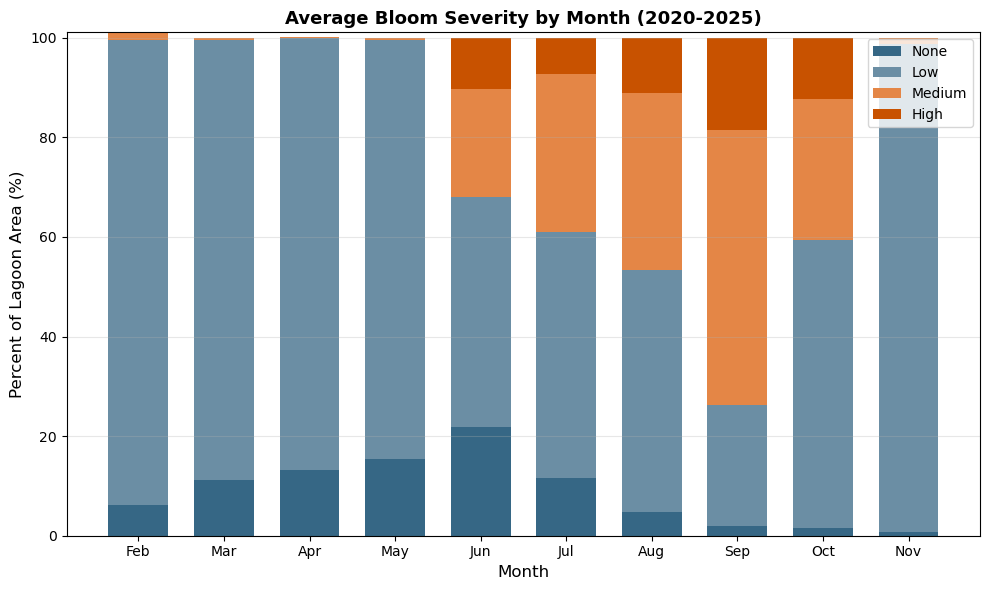

In [138]:
# Extract month and year for seasonal analysis
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Calculate monthly averages across all years
monthly_avg = df.groupby('month')[['none_pct', 'low_pct', 'medium_pct', 'high_pct']].mean()

# Calculate yearly averages
yearly_avg = df.groupby('year')[['none_pct', 'low_pct', 'medium_pct', 'high_pct']].mean()

# Month labels for x-axis
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Stacked bar chart of bloom severity by month
fig, ax = plt.subplots(figsize=(10, 6))
months = monthly_avg.index
bar_width = 0.7

ax.bar(months, monthly_avg['none_pct'], bar_width, label='None', color='#366785')
ax.bar(months, monthly_avg['low_pct'], bar_width, bottom=monthly_avg['none_pct'], 
       label='Low', color='#6b8ea4')
ax.bar(months, monthly_avg['medium_pct'], bar_width, 
       bottom=monthly_avg['none_pct'] + monthly_avg['low_pct'], 
       label='Medium', color='#e48646')
ax.bar(months, monthly_avg['high_pct'], bar_width, 
       bottom=monthly_avg['none_pct'] + monthly_avg['low_pct'] + monthly_avg['medium_pct'], 
       label='High', color='#c85200')

ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Percent of Lagoon Area (%)', fontsize=12)
ax.set_title('Average Bloom Severity by Month (2020-2025)', fontsize=13, fontweight='bold')
ax.set_xticks(months)
ax.set_xticklabels([month_labels[m-1] for m in months])
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# # Print summary statistics
# print("\nMonthly Average Bloom Percentages:")
# print("-" * 60)
# monthly_avg_display = monthly_avg.copy()
# monthly_avg_display.index = [month_labels[m-1] for m in monthly_avg_display.index]
# print(monthly_avg_display.round(2).to_string())


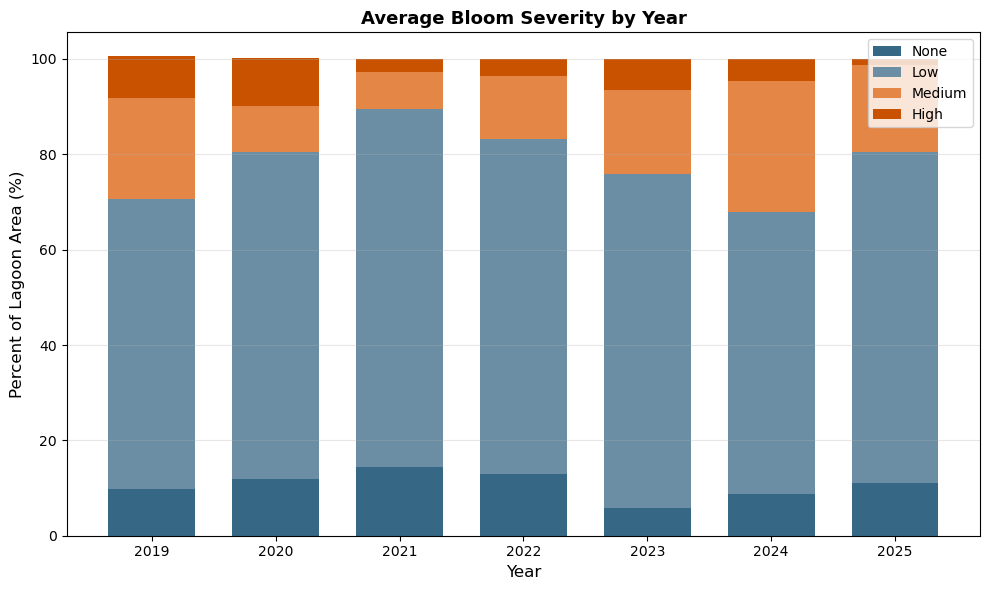

In [139]:
# Stacked bar chart of bloom severity by year
fig, ax = plt.subplots(figsize=(10, 6))
years = yearly_avg.index
bar_width = 0.7

ax.bar(years, yearly_avg['none_pct'], bar_width, label='None', color='#366785')
ax.bar(years, yearly_avg['low_pct'], bar_width, bottom=yearly_avg['none_pct'], 
       label='Low', color='#6b8ea4')
ax.bar(years, yearly_avg['medium_pct'], bar_width, 
       bottom=yearly_avg['none_pct'] + yearly_avg['low_pct'], 
       label='Medium', color='#e48646')
ax.bar(years, yearly_avg['high_pct'], bar_width, 
       bottom=yearly_avg['none_pct'] + yearly_avg['low_pct'] + yearly_avg['medium_pct'], 
       label='High', color='#c85200')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Percent of Lagoon Area (%)', fontsize=12)
ax.set_title('Average Bloom Severity by Year', fontsize=13, fontweight='bold')
ax.set_xticks(years)
ax.set_xticklabels(years)
ax.legend(loc='upper right')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
